In [1]:
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [2]:
import numpy as np
import functools
import random
import datetime
import scipy
import h5py
import os
import pathlib
import nrrd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib
import sys
import json
import skimage
from skimage import io, draw
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from scipy.ndimage import zoom
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [46]:
def create_dataset(img_folder):
   
    img_data_array=[]
    mask_array=[]
    for dir1 in os.listdir(img_folder):
        i=0
        for file in os.listdir(os.path.join(img_folder, dir1)):
            # reading nrrd images
            if (file.endswith(".nrrd")) and (i < 5):
                #file = glob.glob(img_folder + dir1 +'/*.nrrd')[i]
                i = i+1
                image_path= os.path.join(img_folder, dir1, file)
                image, header = nrrd.read(image_path)
                
                image_c = np.delete(image,np.s_[113::1], axis=2) #113
                image_c = np.delete(image_c,np.s_[:24:1], axis=2)
                
                image_c = zoom(image_c, (0.705, 0.588, 0.179))#0.359
                image_c = np.array(image_c)
                image_c [image_c<0] = 0
                image_c = image_c / np.max(image_c)
                image_c = image_c.astype(np.float32)
                
                img =np.rot90(np.transpose(image_c, (2, 1, 0)), 2, (1,2))
                img = np.transpose(img, (2, 1, 0))
                img = img[::-1, :, :]
            
                img_data_array.append(img)
                # reading markups
                j = 0
            if (file.endswith(".json")) and j<1:
                #json_filename = glob(img_folder +  '/*.json')[-1]
                #data = open(json_filename,'r')
                json_path= os.path.join(img_folder, dir1, file)
                data = open(json_path,'r')
                
                jsondata = data.read()
                # Parse
                obj=json.loads(jsondata)
                list=obj['markups']
                # getting LPS coordinates
                points1 = list[0]["controlPoints"][0]["position"]
                points2 = list[0]["controlPoints"][1]["position"]
                points3 = list[0]["controlPoints"][2]["position"]
                # converting to i,j,k coordinate
                i1 = round((points1[0]-header['space origin'][0])/header['space directions'][0][0])
                j1 = round((points1[1]-header['space origin'][1])/header['space directions'][1][1])
                k1 = round((points1[2]-header['space origin'][2])/header['space directions'][2][2])
                i2 = round((points2[0]-header['space origin'][0])/header['space directions'][0][0])
                j2 = round((points2[1]-header['space origin'][1])/header['space directions'][1][1])
                k2 = round((points2[2]-header['space origin'][2])/header['space directions'][2][2])
                i3 = round((points3[0]-header['space origin'][0])/header['space directions'][0][0])
                j3 = round((points3[1]-header['space origin'][1])/header['space directions'][1][1])
                k3 = round((points3[2]-header['space origin'][2])/header['space directions'][2][2])
                # correcting coordinates of mask for resized image and creating mask
                i_s = int(round((i1-(i3-i1))*0.705))  # starting points of 3D cuboid box mask
                j_s = int(round((j1-(j2-j1))*0.588))

                i_e = int(round((i1+(i3-i1))*0.705))   # ending points of 3D cuboid box mask
                j_e = int(round((j1+(j2-j1))*0.588))
                
                k_s = int(round(k2-26)*0.21)  
                k_e = int(round(k2-22)*0.21)
                
                # Making 3D cuboid box mask
                rr, cc, dd = skimage.draw.rectangle(start=(i_s, j_s, k_s), end=(i_e, j_e, k_e)) 
                mask = np.zeros(shape=(image_c.shape[0], image_c.shape[1], image_c.shape[2]), dtype="bool")
                mask[rr, cc, dd] = True
                mask = mask[:, ::-1, :]
                all_masks = [mask] * i
                mask_array.append(all_masks)
        
    return img_data_array, mask_array 

def combine_dims(a, i=0, n=1):
  """
  Combines dimensions of numpy array `a`, starting at index `i`, and combining `n` dimensions
  """
  a = np.array(a)
  s = list(a.shape)
  combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
  return np.reshape(a, s[:i] + [combined] + s[i+n+1:])


#################################################################################
### extract the image array and mask array
img_data_train, mask_all_train =create_dataset(r'C:/Dhruba Research Drive/zzz')
#img_data_val, mask_all_val =create_dataset(r'C:/Dhruba Research Drive/5 nrrd per patient/Validation set')


## For Training Set ###
mask_all_train = combine_dims(mask_all_train, 0) # combines dimension 1 and 2
#imgs.shape
x1=np.array(img_data_train, np.float32)
#print(x1.shape)
y1=np.array(mask_all_train, np.float32)
#print(y1.shape)

X_train = np.expand_dims(x1, axis=4)
y_train = np.expand_dims(y1, axis=4)

print(X_train.shape)
print(y_train.shape)

(10, 128, 128, 16, 1)
(10, 128, 128, 16, 1)


(16, 128, 128)
(16, 128, 128)


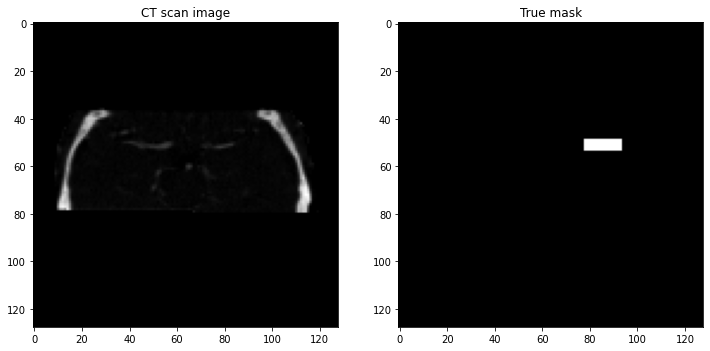

In [44]:
# print(X_train.shape)
# print(y_train.shape)

img_n = 5    # image number
slice = 6  # slice number  (19-23)*0.359

x=np.transpose(x1[img_n], (2, 1, 0))
y=np.transpose(y1[img_n], (2, 1, 0))
print(x.shape)
print(y.shape)
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.title('CT scan image')
plt.imshow(x[slice], cmap='gray')
plt.subplot(122)
plt.title('True mask')
plt.imshow(y[slice], cmap='gray')
plt.show()

In [3]:
def create_dataset(img_folder):
   
    img_data_array=[]
    mask_array=[]
    for dir1 in os.listdir(img_folder):
        i=0
        for file in os.listdir(os.path.join(img_folder, dir1)):
            # reading nrrd images
            if (file.endswith(".nrrd")) and (i < 5):
                #file = glob.glob(img_folder + dir1 +'/*.nrrd')[i]
                i = i+1
                image_path= os.path.join(img_folder, dir1, file)
                image, header = nrrd.read(image_path)
                
                image_c = np.delete(image,np.s_[113::1], axis=2) #113
                image_c = np.delete(image_c,np.s_[:24:1], axis=2)
                
                image_c = zoom(image_c, (0.705, 0.588, 0.359))
                image_c = np.array(image_c)
                image_c [image_c<0] = 0
                image_c = image_c / np.max(image_c)
                image_c = image_c.astype(np.float32)
                
                image_c =np.rot90(np.transpose(image_c, (2, 1, 0)), 2, (1,2))
                image_c = np.transpose(image_c, (2, 1, 0))
                image_c = image_c[::-1, :, :]
            
                img_data_array.append(image_c)
                # reading markups
                j = 0
            if (file.endswith(".json")) and j<1:
                #json_filename = glob(img_folder +  '/*.json')[-1]
                #data = open(json_filename,'r')
                json_path= os.path.join(img_folder, dir1, file)
                data = open(json_path,'r')
                
                jsondata = data.read()
                # Parse
                obj=json.loads(jsondata)
                list=obj['markups']
                # getting LPS coordinates
                points1 = list[0]["controlPoints"][0]["position"]
                points2 = list[0]["controlPoints"][1]["position"]
                points3 = list[0]["controlPoints"][2]["position"]
                # converting to i,j,k coordinate
                i1 = round((points1[0]-header['space origin'][0])/header['space directions'][0][0])
                j1 = round((points1[1]-header['space origin'][1])/header['space directions'][1][1])
                k1 = round((points1[2]-header['space origin'][2])/header['space directions'][2][2])
                i2 = round((points2[0]-header['space origin'][0])/header['space directions'][0][0])
                j2 = round((points2[1]-header['space origin'][1])/header['space directions'][1][1])
                k2 = round((points2[2]-header['space origin'][2])/header['space directions'][2][2])
                i3 = round((points3[0]-header['space origin'][0])/header['space directions'][0][0])
                j3 = round((points3[1]-header['space origin'][1])/header['space directions'][1][1])
                k3 = round((points3[2]-header['space origin'][2])/header['space directions'][2][2])
                # correcting coordinates of mask for resized image and creating mask
                i_s = int(round((i1-(i3-i1))*0.705))  # starting points of 3D cuboid box mask
                j_s = int(round((j1-(j2-j1))*0.588))

                i_e = int(round((i1+(i3-i1))*0.705))   # ending points of 3D cuboid box mask
                j_e = int(round((j1+(j2-j1))*0.588))
                
                k_s = int(round(k2-25)*0.359)  
                k_e = int(round(k2-23)*0.359)
                
                # Making 3D cuboid box mask
                rr, cc, dd = skimage.draw.rectangle(start=(i_s, j_s, k_s), end=(i_e, j_e, k_e)) 
                mask = np.zeros(shape=(image_c.shape[0], image_c.shape[1], image_c.shape[2]), dtype="bool")
                mask[rr, cc, dd] = True
                mask = mask[:, ::-1, :]
                all_masks = [mask] * i
                mask_array.append(all_masks)
        
    return img_data_array, mask_array 

def combine_dims(a, i=0, n=1):
  """
  Combines dimensions of numpy array `a`, starting at index `i`, and combining `n` dimensions
  """
  a = np.array(a)
  s = list(a.shape)
  combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
  return np.reshape(a, s[:i] + [combined] + s[i+n+1:])


#################################################################################
### extract the image array and mask array
img_data_train, mask_all_train =create_dataset(r'C:/Dhruba Research Drive/Detection dataset/CTP MNI segmented LVO')
img_data_val, mask_all_val =create_dataset(r'C:/Dhruba Research Drive/Detection dataset/Val Set')


## For Training Set ###
mask_all_train = combine_dims(mask_all_train, 0) # combines dimension 1 and 2
# #imgs.shape
# x1=np.array(img_data_train, np.float32)
# #print(x1.shape)
# y1=np.array(mask_all_train, np.float32)
# #print(y1.shape)

# X_train = np.expand_dims(x1, axis=4)
# y_train = np.expand_dims(y1, axis=4)

## For Validation Set ###
mask_all_val = combine_dims(mask_all_val, 0) # combines dimension 1 and 2
#imgs.shape
img_data_val=np.array(img_data_val, np.float32)
#print(x1.shape)
mask_all_val=np.array(mask_all_val, np.float32)
#print(y1.shape)

X_val = np.expand_dims(img_data_val, axis=4)
y_val = np.expand_dims(mask_all_val, axis=4)

# print(X_train.shape)
# print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

img_aug_array=[]
mask_aug_array=[]
for d in range (mask_all_train.shape[0]):
#     img = img_data_train[d]
#     mask = mask_all_train[d]
    for e in range (4):
        img = np.rot90(np.transpose(img_data_train[d], (2, 1, 0)), e, (1,2))
        img = np.transpose(img, (2, 1, 0))
        img_aug_array.append(img)
        mask = np.rot90(np.transpose(mask_all_train[d], (2, 1, 0)), e, (1,2))
        mask = np.transpose(mask, (2, 1, 0))
        mask_aug_array.append(mask)

X_train_aug = np.array(img_aug_array, np.float32)
X_train_aug = np.expand_dims(X_train_aug, axis=4)
print(X_train_aug.shape)

y_train_aug = np.array(mask_aug_array, np.float32)
y_train_aug = np.expand_dims(y_train_aug, axis=4)
print(y_train_aug.shape)

(185, 128, 128, 32, 1)
(185, 128, 128, 32, 1)


In [153]:
def RB1(inp, f):              # Residual unit 1
    X = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same')(inp)
    X = BatchNormalization(axis = -1)(X)
    X = Activation('relu')(X)
    X = Conv3D(f, kernel_size = (3,3,3), padding = 'same')(X)
    X = BatchNormalization(axis = -1)(X)
    
    # Conv attention module
    X = cbam_block(X)
    
    X_s = Conv3D(f, kernel_size = (3,3,3), padding = 'same')(inp)
    X_s = BatchNormalization(axis = -1)(X_s)
    
    X = layers.Add()([X, X_s])
    out = Activation('relu')(X)
    return out

def RB2(inp, f):             # Residual unit 2
    X = Conv3D(filters = f, kernel_size = (3,3,3), padding = 'same')(inp)
    X = BatchNormalization(axis = -1)(X)
    X = Activation('relu')(X)
    X = Conv3D(f, kernel_size = (3,3,3), padding = 'same')(X)
    X = BatchNormalization(axis = -1)(X)
    
    # Conv attention module
    X = cbam_block(X)
    
    X = layers.Add()([X, inp])
    out = Activation('relu')(X)
    return out

def cbam_block(cbam_feature, ratio=16):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521."""

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature


def channel_attention(input_feature, ratio=16):

    channel = input_feature.shape[-1] # if channel last, axis = -1 or if channel first then axis = 1
    i_shape = input_feature.shape[1]  #shape of input 

    shared_layer_one = Conv3D(channel//ratio, 1, activation='relu', use_bias=False)
    shared_layer_two = Conv3D(channel, 1, use_bias=False)

    avg_pool = AveragePooling3D(pool_size=(i_shape, i_shape, i_shape), strides=i_shape, padding='same')(input_feature)    
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = MaxPooling3D(pool_size=(i_shape, i_shape, i_shape), strides=i_shape, padding='same')(input_feature)  
    max_pool = shared_layer_one(max_pool)  
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    #if channel first then use this
    #cbam_feature = Permute((4, 1, 2, 3))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7

    channel = input_feature.shape[-1]  # if channel last, axis = -1 or if channel first then axis = 1
    #if channel first then use this
    #cbam_feature = Permute((2,3,4,1))(input_feature)

    avg_pool = Lambda(lambda x: K.mean(x, axis=4, keepdims=True))(input_feature)  #(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=4, keepdims=True))(input_feature)  #(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=4)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv3D(filters = 1, kernel_size=kernel_size, strides=1, padding='same',
                    activation=None, kernel_initializer='he_normal', use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1
    cbam_feature = tf.sigmoid(cbam_feature, 'sigmoid')
    
    #if channel first then use this
    #cbam_feature = Permute((4, 1, 2, 3))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])

def A1(inp): 
    A1 = Conv3D(inp.shape[-1], kernel_size=(3,3,3), dilation_rate=1, padding='same')(inp)
    return A1

def A3(inp): 
    A3 = Conv3D(inp.shape[-1], kernel_size=(3,3,3), dilation_rate=3, padding='same')(inp)
    return A3

def A5(inp):
    A5 = Conv3D(inp.shape[-1], kernel_size=(3,3,3), dilation_rate=5, padding='same')(inp)
    return A5  

def conv1x1(inp):
    conv1x1 = Conv3D(inp.shape[-1], kernel_size=(3,3,3), dilation_rate=1, padding='same')(inp)
    return conv1x1
    
def DAC(inp):
    
    atrous1 =  tf.nn.relu(A1(inp))
    atrous2 =  tf.nn.relu(conv1x1(A3(inp)))
    atrous3 =  tf.nn.relu(conv1x1(A3(A1(inp))))
    atrous4 =  tf.nn.relu(conv1x1(A5(A3(A1(inp)))))
    
    out = Add()([atrous1, atrous2, atrous3, atrous4])
    return out

def _resize_by_axis_trilinear(images, size_0, size_1, ax):
    """
    Resize image bilinearly to [size_0, size_1] except axis ax.
        :param image: a tensor 4-D with shape 
                        [batch, d0, d1, d2, channels]
        :param size_0: size 0
        :param size_1: size 1
        :param ax: axis to exclude from the interpolation
    """
    resized_list = []

    # unstack the image in 2d cases
    unstack_list = tf.unstack(images, axis = ax)
    for i in unstack_list:
        # resize bilinearly
        resized_list.append(tf.compat.v1.image.resize_bilinear(i, [size_0, size_1]))
    stack_img = tf.stack(resized_list, axis=ax)

    return stack_img


def resize_trilinear(images, size):
    """
    Resize images to size using trilinear interpolation.
        :param images: A tensor 5-D with shape 
                        [batch, d0, d1, d2, channels]
        :param size: A 1-D int32 Tensor of 3 elements: new_d0, new_d1,
                        new_d2. The new size for the images.
    """
    assert size.shape[0] == 3
    resized = _resize_by_axis_trilinear(images, size[0], size[1], 2)
    resized = _resize_by_axis_trilinear(resized, size[0], size[2], 1)
    return resized


# jumping some lines...


def resize_multilinear_tf(images, size):
    """
    Resize images to size using multilinear interpolation.
        :param images: A tensor with shape 
                        [batch, d0, ..., dn, channels]
        :param size: A 1-D int32 Tensor. The new size for the images.
    """
    if size.shape[0] == 2:
        resized = tf.compat.v1.image.resize_bilinear(images, size)
    elif size.shape[0] == 3:
        resized = resize_trilinear(images, size)
#     elif size.shape[0] == 4:
#         resized = resize_tetralinear(images, size)
    else:
        raise NotImplementedError('resize_multilinear_tf: dimensions \
                                    higuer than 3 are not supported.')
    return resized


########### We do not use this 'resize_by_axis' in this project ############3
def resize_by_axis(image, dim_1, dim_2, ax, is_grayscale):

    resized_list = []


    if is_grayscale:
        unstack_img_depth_list = [tf.expand_dims(x,2) for x in tf.unstack(image, axis = ax)]
        for i in unstack_img_depth_list:
            resized_list.append(tf.compat.v1.image.resize_images(i, [dim_1, dim_2],method=0))
        stack_img = tf.squeeze(tf.stack(resized_list, axis=ax))
        print(stack_img.get_shape())

    else:
        unstack_img_depth_list = tf.unstack(image, axis = ax)
        for i in unstack_img_depth_list:
            resized_list.append(tf.compat.v1.image.resize_images(i, [dim_1, dim_2],method=0))
        stack_img = tf.stack(resized_list, axis=ax)

    return stack_img

# resized_along_depth = resize_by_axis(x,8,8,2, True)
# resized_along_width = resize_by_axis(resized_along_depth,8,8,1,True)

#################################################################################



# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

inputs = Input((128,128,32,1))

# 3D Conv layers starts below
conv1 = Conv3D(24, kernel_size=(3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv3D(24, kernel_size=(3,3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2, padding='same')(conv1)


# Residual block 1
X1 = RB1(pool1, 32)
X1 = RB2(X1, 32)
X1 = RB2(X1, 32)
pool2 = MaxPooling3D(pool_size=(2, 2, 2), strides=2, padding='same')(X1)

# Residual block 2
X2 = RB1(pool2, 64)
X2 = RB2(X2, 64)
X2 = RB2(X2, 64)
pool3 = MaxPooling3D(pool_size=(2, 2, 2), strides=2, padding='same')(X2)

# Residual block 3
X3 = RB2(pool3, 64) #input shapes matches, so no need for RB1
X3 = RB2(X3, 64)
X3 = RB2(X3, 64)
pool4 = MaxPooling3D(pool_size=(2, 2, 2), strides=2, padding='same')(X3)

# Residual block 4
X4 = RB2(pool4, 64) #input shapes matches, so no need for RB1
X4 = RB2(X4, 64)
X4 = RB2(X4, 64)

dense_atrous_conv = DAC(X4)

size = np.ones((3), dtype=np.int32)
size[0] = dense_atrous_conv.shape[1]
size[1] = dense_atrous_conv.shape[2]
size[2] = dense_atrous_conv.shape[3]

#pooling1 = pool2(dense_atrous_conv)
pool2 = MaxPooling3D(pool_size=(2, 2, 2), strides=2, padding='same')(dense_atrous_conv)
pool2 = Conv3D(1, kernel_size=1, padding='same')(pool2)
pool2 = resize_multilinear_tf(pool2, size)

#pooling2 = pool3(dense_atrous_conv)
pool3 = MaxPooling3D(pool_size=(3, 3, 3), strides=3, padding='same')(dense_atrous_conv)
pool3 = Conv3D(1, kernel_size=1, padding='same')(pool3)
pool3 = resize_multilinear_tf(pool3, size)

#pooling3 = pool5(dense_atrous_conv)
pool5 = MaxPooling3D(pool_size=(5, 5, 5), strides=5, padding='same')(dense_atrous_conv)
pool5 = Conv3D(1, kernel_size=1, padding='same')(pool5)
pool5 = resize_multilinear_tf(pool5, size)

#pooling4 = pool6(dense_atrous_conv)
pool6 = MaxPooling3D(pool_size=(6, 6, 6), strides=6,  padding='same')(dense_atrous_conv)
pool6 = Conv3D(1, kernel_size=1, padding='same')(pool6)
pool6 = resize_multilinear_tf(pool6, size)
     
Multi_Kernel_Pooling = tf.concat([pool2, pool3, pool5, pool6, dense_atrous_conv], -1)

#Multi_Kernel_Pooling = RMP(dense_atrous_conv)

## Feedback path ##
# Deconvolutional Layer 1
deconv1 = Conv3DTranspose(64, kernel_size = 2, strides=(2, 2, 2), padding='same')(Multi_Kernel_Pooling)#(dense_atrous_conv)

# Combining Unit 1
C1 = tf.keras.layers.concatenate([deconv1, X3], axis = -1)

# Residual block 5
X5 = RB1(C1, 64) 
X5 = RB2(X5, 64)
X5 = RB2(X5, 64)

# Deconvolutional Layer 2
deconv2 = Conv3DTranspose(64, kernel_size = 2, strides=(2, 2, 2), padding='same')(X5)

# Combining Unit 2
C2 = tf.keras.layers.concatenate([deconv2, X2], axis = -1)

# Residual block 6
X6 = RB2(C2, 128)  #input shapes matches, so no need for RB1
X6 = RB2(X6, 128)
X6 = RB2(X6, 128)

deconv3 = Conv3DTranspose(32, kernel_size = 2, strides=(2, 2, 2), padding='same')(X6)

deconv4 = Conv3DTranspose(24, kernel_size = 2, strides=(2, 2, 2), padding='same')(deconv3)

##########################################################################################

# Final 3D Conv layers 
conv2 = Conv3D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(deconv4)
conv2 = Conv3D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
conv2 = Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
conv2 = Conv3D(1, 1, activation = 'sigmoid')(conv2)

model = Model(inputs = inputs, outputs = conv2)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 32 0                                            
__________________________________________________________________________________________________
conv3d_339 (Conv3D)             (None, 128, 128, 32, 672         input_4[0][0]                    
__________________________________________________________________________________________________
conv3d_340 (Conv3D)             (None, 128, 128, 32, 15576       conv3d_339[0][0]                 
__________________________________________________________________________________________________
max_pooling3d_78 (MaxPooling3D) (None, 64, 64, 16, 2 0           conv3d_340[0][0]                 
____________________________________________________________________________________________

In [154]:
# #this is for tensorboard logs
# log_dir = 'logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=False,
                             mode='min')
#callbacks = [checkpoint, history_logger]
callbacks = [checkpoint]

#for Adam optimizer
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

###########################################################

ALPHA = 0.2
BETA = 0.8
GAMMA = 1   #0.75
SMOOTH=1e-9

def FocalTversky(y_true, y_pred, smooth=SMOOTH, alpha=ALPHA, beta=BETA):
    
        # Don't flatten label and prediction tensors
        y_true_pos = y_true
        y_pred_pos = y_pred
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((y_true_pos * y_pred_pos))
        FN = K.sum((y_true * (1-y_pred_pos)))
        FP = K.sum(((1-y_true_pos) * y_pred_pos))      
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        return Tversky
    
def FocalTverskyLoss(y_true, y_pred, gamma=GAMMA):
        tv = FocalTversky(y_true, y_pred)
        FocalTversky_m = K.pow((1 - tv), gamma) 
        return FocalTversky_m
    
optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optim = tf.keras.optimizers.Adam(learning_rate=0.0001)


model.compile(optimizer=optim,
              loss=FocalTverskyLoss,
              metrics=[FocalTversky])


result = model.fit(X_train_aug,
                    y_train_aug,
                    batch_size = 10,
                    epochs = 15,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

model.save('MNI_LVO_detection_epochs15.h5')

Train on 3000 samples, validate on 185 samples
Epoch 1/15
3000/3000 [==============================] - ETA: 0s - loss: 0.7299 - FocalTversky: 0.2701
Epoch 00001: saving model to my_best_model.epoch01-loss0.70.hdf5
3000/3000 [==============================] - 855s 285ms/sample - loss: 0.7299 - FocalTversky: 0.2701 - val_loss: 0.7031 - val_FocalTversky: 0.2971
Epoch 2/15
3000/3000 [==============================] - ETA: 0s - loss: 0.6566 - FocalTversky: 0.3434
Epoch 00002: saving model to my_best_model.epoch02-loss0.63.hdf5
3000/3000 [==============================] - 738s 246ms/sample - loss: 0.6566 - FocalTversky: 0.3434 - val_loss: 0.6325 - val_FocalTversky: 0.3643
Epoch 3/15
3000/3000 [==============================] - ETA: 0s - loss: 0.6351 - FocalTversky: 0.3649
Epoch 00003: saving model to my_best_model.epoch03-loss0.61.hdf5
3000/3000 [==============================] - 739s 246ms/sample - loss: 0.6351 - FocalTversky: 0.3649 - val_loss: 0.6142 - val_FocalTversky: 0.3857
Epoch 4/15


KeyboardInterrupt: 

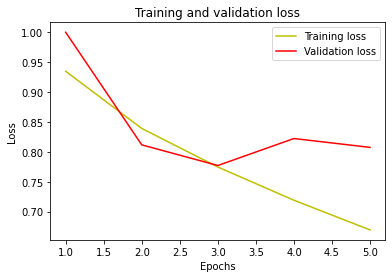

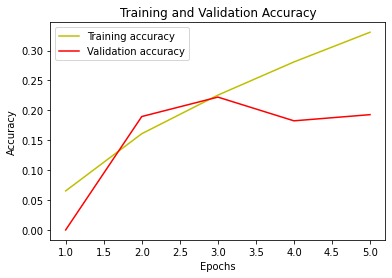

In [8]:
loss=result.history['loss']
val_loss=result.history['val_loss']
epochs=range(1, len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = result.history['FocalTversky']
val_acc = result.history['val_FocalTversky']

plt.plot(epochs, acc, 'y', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [4]:
#Load and evaluate the best model version
best_model = load_model('my_best_model.epoch06-loss0.58.hdf5', compile = False)
# yhat = model.predict(X_test)

In [56]:
# ##for Adam optimizer
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-4,
#     decay_steps=10000,
#     decay_rate=0.9)

# ###########################################################

# ALPHA = 0.3
# BETA = 0.7
# GAMMA = 0.75
# SMOOTH=1e-9

# def FocalTversky(y_true, y_pred, smooth=SMOOTH, alpha=ALPHA, beta=BETA):
    
#         # Don't flatten label and prediction tensors
#         y_true_pos = y_true
#         y_pred_pos = y_pred
        
#         #True Positives, False Positives & False Negatives
#         TP = K.sum((y_true_pos * y_pred_pos))
#         FN = K.sum((y_true * (1-y_pred_pos)))
#         FP = K.sum(((1-y_true_pos) * y_pred_pos))      
#         Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
#         return Tversky
    
# def FocalTverskyLoss(y_true, y_pred, gamma=GAMMA):
#         tv = FocalTversky(y_true, y_pred)
#         FocalTversky_m = K.pow((1 - tv), gamma) 
#         return FocalTversky_m
    
# optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# best_model.compile(optimizer=optim,
#               loss=FocalTverskyLoss,
#               metrics=[FocalTversky])

# test_patient_loss, test_patient_acc = best_model.evaluate(X_val, y_val, batch_size=10)
# print(test_patient_loss, test_patient_acc) ##for conv3 (3,3,6 with augmented data)

0.7710205219887398 0.29360494


(128, 128, 32)
(128, 128, 32)


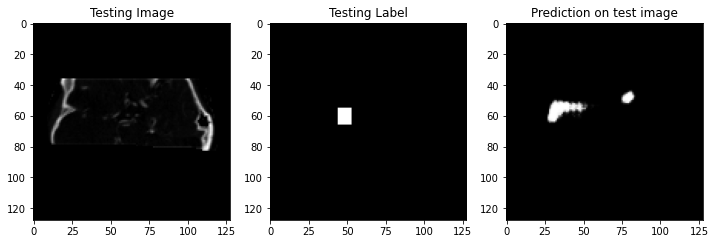

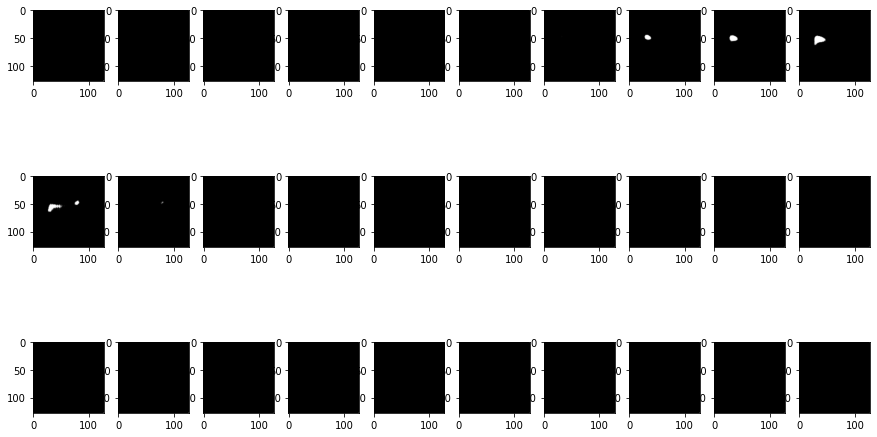

In [155]:
#test_img_number = random.randint(0, len(X_test))
test_img_number = 156
test_img = X_val[test_img_number]
ground_truth=y_val[test_img_number]

test_img_input = np.expand_dims(test_img, 0)

test_pred1 = best_model.predict(test_img_input)
#test_prediction1 = np.argmax(test_pred1, axis = 4)[0, :, :, :]
test_prediction1 = test_pred1[0, :, :, :, 0]
print(test_prediction1.shape)
ground_truth_argmax = ground_truth[:, :, :, 0]

print(test_prediction1.shape)
##plot the individual slices from test predictions 

slice = 11  #6-7 !!!
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Testing Image')
x_t=np.transpose(test_img, (2, 1, 0, 3))
#x_t = x_t[:, :, :, 0]
plt.imshow(x_t[slice], cmap='gray')
#plt.imshow(test_img[slice,:,:,0], cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
y_t=np.transpose(ground_truth_argmax, (2, 1, 0))
plt.imshow(y_t[slice], cmap ='gray')

plt.subplot(233)
plt.title('Prediction on test image')
y_p = np.transpose(test_prediction1, (2, 1, 0))
plt.imshow(y_p[slice], cmap = 'gray')
plt.show()

plt.figure(figsize=(15,30))
for i in range(30):
    plt.subplot(10, 10, i+1)
    plt.imshow(y_p[(i+1)], cmap='gray')

In [151]:
plt.imsave("prediction.jpg", y_p[slice], cmap = 'gray')
plt.imsave("ground_truth.jpg", y_t[slice], cmap = 'gray')
x_t = x_t[:, :, :, 0]
plt.imsave("patient_brain.jpg", x_t[slice], cmap = 'gray')
plt.imsave("patient_brain_1.jpg", x_t[slice], cmap = 'gray')

x,y,w,h: 30 48 16 16


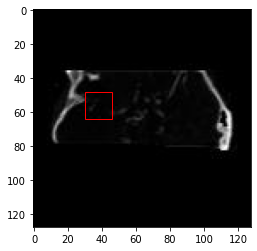

In [153]:
# import cv2
# import numpy as np
# import matplotlib
# from matplotlib import pyplot
# import matplotlib.patches as patches

img = cv2.imread('prediction.jpg')


# convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# threshold
thresh = cv2.threshold(gray,128,255,cv2.THRESH_BINARY)[1]

# get contours
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    cv2.rectangle(cntr, (x, y), (x+w, y+h), (0, 0, 255), 2)
    print("x,y,w,h:",x,y,w,h)
 
# save resulting image
cv2.imwrite('pred_patient_7_39-43_threshold.jpg',img)      

# show thresh and result    
# cv2.imshow("bounding_box", img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


image_p = matplotlib.image.imread("patient_brain.jpg")

figure, ax = pyplot.subplots(1)

rect1 = patches.Rectangle((x,y),w,h, edgecolor='r', facecolor="none")
#rect2 = patches.Rectangle((27,50),13,13, edgecolor='r', facecolor="none")


ax.imshow(image_p)

ax.add_patch(rect1)
#ax.add_patch(rect2)

x,y,w,h: 44 55 9 11


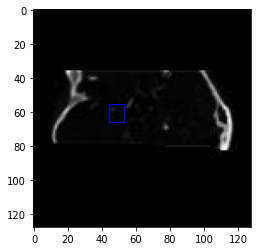

In [116]:
import cv2
import numpy as np

# read image
img = cv2.imread('ground_truth.jpg')

# convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# threshold
thresh = cv2.threshold(gray,128,255,cv2.THRESH_BINARY)[1]

# get contours
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    cv2.rectangle(cntr, (x, y), (x+w, y+h), (0, 0, 255), 2)
    print("x,y,w,h:",x,y,w,h)
 
# save resulting image
cv2.imwrite('prediction_threshold.jpg',img)      

# show thresh and result    
# cv2.imshow("bounding_box", result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

#x_t = x_t[:, :, :, 0]
# plt.imsave("patient_brain_1.jpg", x_t[28], cmap = 'gray')
image_t = matplotlib.image.imread("patient_brain_1.jpg")

figure, ax = pyplot.subplots(1)

rect = patches.Rectangle((x,y),w,h, edgecolor='b', facecolor="none")

ax.imshow(image_t)

ax.add_patch(rect)

(128, 128, 32)
(128, 128, 32)


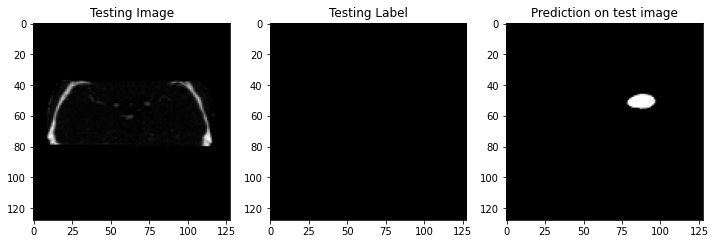

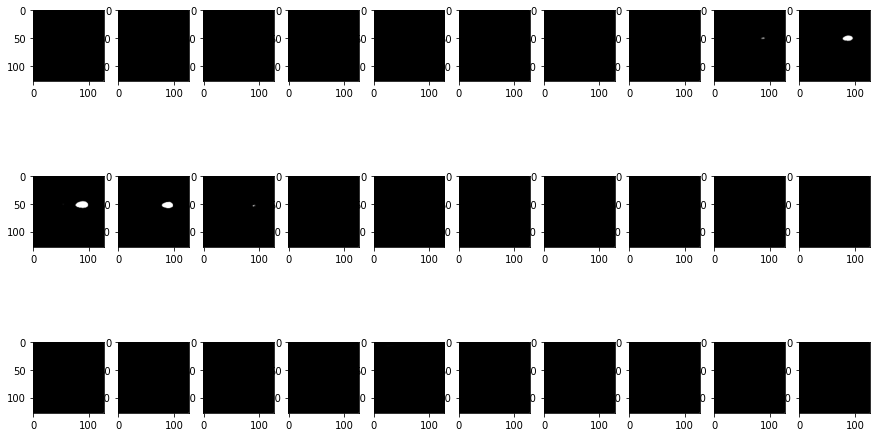

In [549]:
#test_img_number = random.randint(0, len(X_test))
test_img_number = 184
test_img = X_test_n[test_img_number]
ground_truth=y_test_n[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = best_model.predict(test_img_input)
#test_prediction1 = np.argmax(test_pred1, axis = 4)[0, :, :, :]
test_prediction1 = test_pred1[0, :, :, :, 0]
print(test_prediction1.shape)
ground_truth_argmax = ground_truth[:, :, :, 0]
print(test_prediction1.shape)
##plot the individual slices from test predictions 
slice = 10  #24-32 !!!
plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Testing Image')
x_t=np.transpose(test_img, (2, 1, 0, 3))
#x_t = x_t[:, :, :, 0]
plt.imshow(x_t[slice], cmap='gray')
#plt.imshow(test_img[slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
y_t=np.transpose(ground_truth_argmax, (2, 1, 0))
plt.imshow(y_t[slice], cmap ='gray')
plt.subplot(233)
plt.title('Prediction on test image')
y_p = np.transpose(test_prediction1, (2, 1, 0))
plt.imshow(y_p[slice], cmap = 'gray')
plt.show()
plt.figure(figsize=(15,30))
for i in range(30):
    plt.subplot(10, 10, i+1)
    plt.imshow(y_p[(i+1)], cmap='gray')

In [401]:
def create_dataset_n(img_folder):
   
    img_data_array=[]
    mask_array=[]
    for dir1 in os.listdir(img_folder):
        i=0
        for file in os.listdir(os.path.join(img_folder, dir1)):
            # reading nrrd images
            if (file.endswith(".nrrd")) and (i < 5):
                #file = glob.glob(img_folder + dir1 +'/*.nrrd')[i]
                i = i+1
                image_path= os.path.join(img_folder, dir1, file)
                image, header = nrrd.read(image_path)
                
                image_c = np.delete(image,np.s_[113::1], axis=2)
                image_c = np.delete(image_c,np.s_[:24:1], axis=2)
                
                image_c = zoom(image_c, (0.705, 0.588, 0.359)) #1.438 for 128x128x128 and 0.359 for 128x128x32
                image_c = np.array(image_c)
                image_c [image_c<0] = 0
                image_c = image_c / np.max(image_c)
                image_c = image_c.astype(np.float32)
                
                image_c =np.rot90(np.transpose(image_c, (2, 1, 0)), 2, (1,2))
                image_c = np.transpose(image_c, (2, 1, 0))
                image_c = image_c[::-1, :, :]
                img_data_array.append(image_c)

                # mask without json for normal patient (without LVO)
                mask = np.zeros(shape=(image_c.shape[0], image_c.shape[1], image_c.shape[2]), dtype="bool")
                mask = mask[:, ::-1, :]
                mask_array.append(mask)
        
    return img_data_array, mask_array 

def combine_dims(a, i=0, n=1):
  """
  Combines dimensions of numpy array `a`, starting at index `i`, and combining `n` dimensions
  """
  a = np.array(a)
  s = list(a.shape)
  combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
  return np.reshape(a, s[:i] + [combined] + s[i+n+1:])


#################################################################################
img_data_test_normal, mask_all_test_normal =create_dataset_n(r'C:/Dhruba Research Drive/Detection dataset/MNI normal val')

## For Test Normal Set ###
#mask_all_test_normal = combine_dims_n(mask_all_test_normal, 0) # combines dimension 1 and 2
x4=np.array(img_data_test_normal, np.float32)
#print(x4.shape)
y4=np.array(mask_all_test_normal, np.float32)
#print(y4.shape)

X_test_n = np.expand_dims(x4, axis=4)
y_test_n = np.expand_dims(y4, axis=4)

print(X_test_n.shape)
print(y_test_n.shape)

(185, 128, 128, 32, 1)
(185, 128, 128, 32, 1)


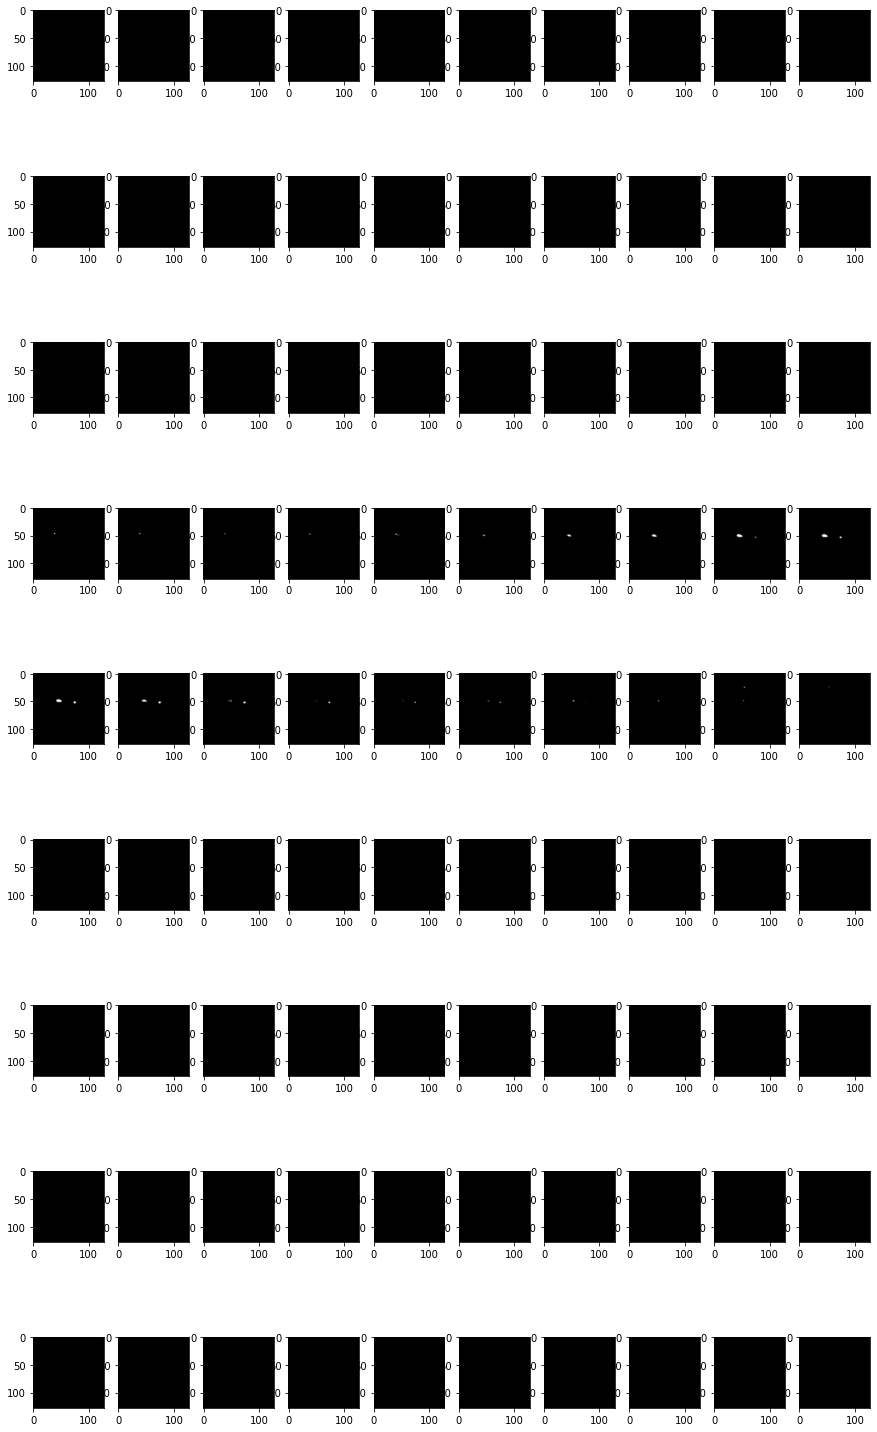

In [539]:
# plt.figure(figsize=(15,30))
# for i in range(90):
#     plt.subplot(10, 10, i+1)
#     plt.imshow(y_p[(i+1)], cmap='gray')

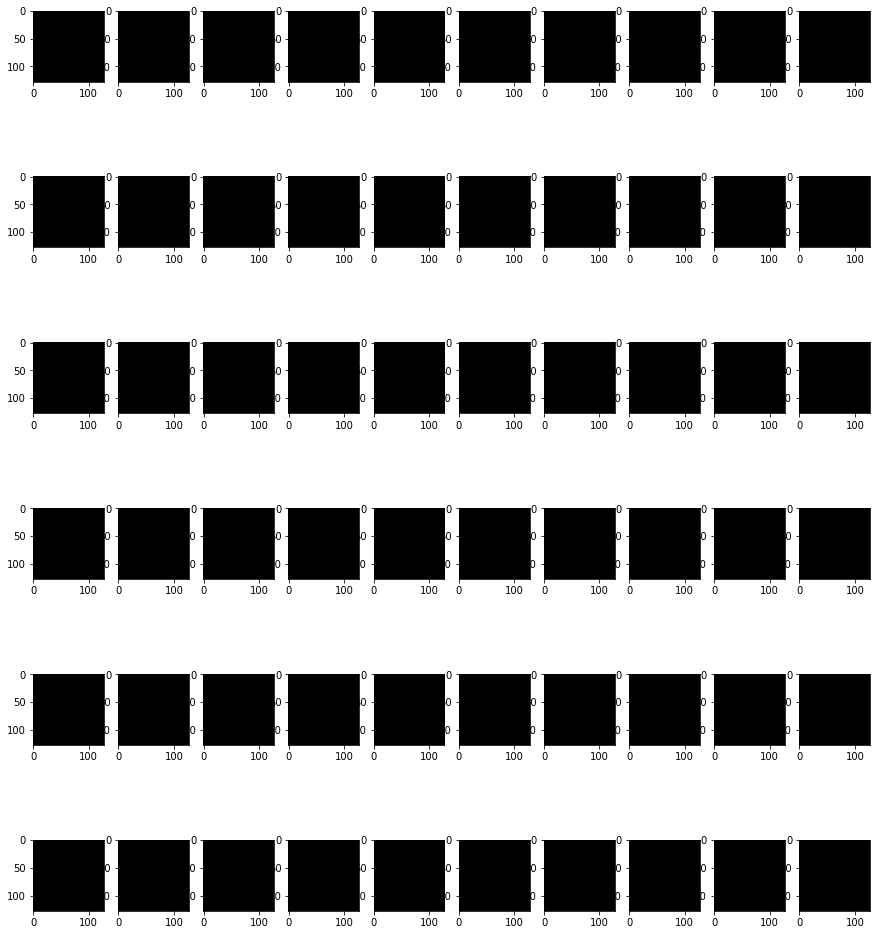

In [508]:
# plt.figure(figsize=(15,30))
# for i in range(60):
#     plt.subplot(10, 10, i+1)
#     plt.imshow(y_t[(i+1)], cmap='gray')

In [479]:
# ALPHA = 0.2
# BETA = 0.8
# GAMMA = 0.75a
# SMOOTH=1e-9

# def create_dataset(img_folder):
   
#     img_data_array=[]
#     mask_array=[]
#     for dir1 in os.listdir(img_folder):
#         i=0
#         for file in os.listdir(os.path.join(img_folder, dir1)):
#             # reading nrrd images
#             if (file.endswith(".nrrd")) and (i < 5):
#                 #file = glob.glob(img_folder + dir1 +'/*.nrrd')[i]
#                 i = i+1
#                 image_path= os.path.join(img_folder, dir1, file)
#                 image, header = nrrd.read(image_path)
                
#                 image_c = np.delete(image,np.s_[113::1], axis=2)
#                 image_c = np.delete(image_c,np.s_[:24:1], axis=2)
                
#                 image_r = zoom(image_c, (0.705, 0.588, 1.438))
#                 image_r = np.array(image_r)
#                 image_r [image_r<0] = 0
#                 image_r = image_r / np.max(image_r)
#                 image_r = image_r.astype(np.float32)
                
#                 img =np.rot90(np.transpose(image_r, (2, 1, 0)), 2, (1,2))
#                 img = np.transpose(img, (2, 1, 0))
#                 img = img[::-1, :, :]
            
#                 img_data_array.append(img)
#                 # reading markups
#                 j = 0
#             if (file.endswith(".json")) and j<1:
#                 #json_filename = glob(img_folder +  '/*.json')[-1]
#                 #data = open(json_filename,'r')
#                 json_path= os.path.join(img_folder, dir1, file)
#                 data = open(json_path,'r')
                
#                 jsondata = data.read()
#                 # Parse
#                 obj=json.loads(jsondata)
#                 list=obj['markups']
#                 # getting LPS coordinates
#                 points1 = list[0]["controlPoints"][0]["position"]
#                 points2 = list[0]["controlPoints"][1]["position"]
#                 points3 = list[0]["controlPoints"][2]["position"]
#                 # converting to i,j,k coordinate
#                 i1 = round((points1[0]-header['space origin'][0])/header['space directions'][0][0])
#                 j1 = round((points1[1]-header['space origin'][1])/header['space directions'][1][1])
#                 k1 = round((points1[2]-header['space origin'][2])/header['space directions'][2][2])
#                 i2 = round((points2[0]-header['space origin'][0])/header['space directions'][0][0])
#                 j2 = round((points2[1]-header['space origin'][1])/header['space directions'][1][1])
#                 k2 = round((points2[2]-header['space origin'][2])/header['space directions'][2][2])
#                 i3 = round((points3[0]-header['space origin'][0])/header['space directions'][0][0])
#                 j3 = round((points3[1]-header['space origin'][1])/header['space directions'][1][1])
#                 k3 = round((points3[2]-header['space origin'][2])/header['space directions'][2][2])
#                 # correcting coordinates of mask for resized image and creating mask
#                 i_s = int(round((i1-(i3-i1))*0.705))  # starting points of 3D cuboid box mask
#                 j_s = int(round((j1-(j2-j1))*0.588))

#                 i_e = int(round((i1+(i3-i1))*0.705))   # ending points of 3D cuboid box mask
#                 j_e = int(round((j1+(j2-j1))*0.588))
                
#                 k_s = int(round(k2-26)*1.438)  
#                 k_e = int(round(k2-22)*1.438)
                
#                 # Making 3D cuboid box mask
#                 rr, cc, dd = skimage.draw.rectangle(start=(i_s, j_s, k_s), end=(i_e, j_e, k_e)) 
#                 mask = np.zeros(shape=(image_r.shape[0], image_r.shape[1], image_r.shape[2]), dtype="bool")
#                 mask[rr, cc, dd] = True
#                 mask = mask[:, ::-1, :]
#                 all_masks = [mask] * i
#                 mask_array.append(all_masks)
        
#     return img_data_array, mask_array 

# def combine_dims(a, i=0, n=1):
#   """
#   Combines dimensions of numpy array `a`, starting at index `i`, and combining `n` dimensions
#   """
#   a = np.array(a)
#   s = list(a.shape)
#   combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
#   return np.reshape(a, s[:i] + [combined] + s[i+n+1:])


# def FocalTversky(y_true, y_pred, smooth=SMOOTH, alpha=ALPHA, beta=BETA):
    
#         # Don't flatten label and prediction tensors
#         y_true_pos = y_true
#         y_pred_pos = y_pred
        
#         #True Positives, False Positives & False Negatives
#         TP = K.sum((y_true_pos * y_pred_pos))
#         FN = K.sum((y_true * (1-y_pred_pos)))
#         FP = K.sum(((1-y_true_pos) * y_pred_pos))      
#         Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
#         return Tversky
    
# def FocalTverskyLoss(y_true, y_pred, gamma=GAMMA):
#         tv = FocalTversky(y_true, y_pred)
#         FocalTversky_m = K.pow((1 - tv), gamma) 
#         return FocalTversky_m

# #################################################################################
# ### extract the image array and mask array
# img_data_train, mask_all_train =create_dataset(r'C:/Dhruba Research Drive/Detection dataset/CTP MNI segmented LVO')
# img_data_val, mask_all_val =create_dataset(r'C:/Dhruba Research Drive/Detection dataset/Val Set')


# ## For Training Set ###
# mask_all_train = combine_dims(mask_all_train, 0) # combines dimension 1 and 2
# #imgs.shape
# x1=np.array(img_data_train, np.float32)
# #print(x1.shape)
# y1=np.array(mask_all_train, np.float32)
# #print(y1.shape)

# X_train = np.expand_dims(x1, axis=4)
# y_train = np.expand_dims(y1, axis=4)

# ## For Validation Set ###
# mask_all_val = combine_dims(mask_all_val, 0) # combines dimension 1 and 2
# #imgs.shape
# x2=np.array(img_data_val, np.float32)
# #print(x1.shape)
# y2=np.array(mask_all_val, np.float32)
# #print(y1.shape)

# X_val = np.expand_dims(x2, axis=4)
# y_val = np.expand_dims(y2, axis=4)

# print(X_train.shape)
# print(y_train.shape)

# print(X_val.shape)
# print(y_val.shape)

# img_aug_array=[]
# mask_aug_array=[]
# for d in range (mask_all_train.shape[0]):
#     img = img_data_train[d]
#     mask = mask_all_train[d]
#     for e in range (4):
#         img = np.rot90(np.transpose(img, (2, 1, 0)), e, (1,2))
#         img = np.transpose(img, (2, 1, 0))
#         img_aug_array.append(img)
#         mask = np.rot90(np.transpose(mask, (2, 1, 0)), e, (1,2))
#         mask = np.transpose(mask, (2, 1, 0))
#         mask_aug_array.append(mask)

# x4=np.array(img_aug_array, np.float32)
# X_train_aug = np.expand_dims(x4, axis=4)
# print(X_train_aug.shape)

# y4=np.array(mask_aug_array, np.float32)
# y_train_aug = np.expand_dims(y4, axis=4)
# print(y_train_aug.shape)

# #for Adam optimizer
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-5,
#     decay_steps=10000,
#     decay_rate=0.9)

# ###########################################################

# # ALPHA = 0.2
# # BETA = 0.8
# # GAMMA = 0.75
# # SMOOTH=1e-9

    
# optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# #optim = tf.keras.optimizers.Adam(learning_rate=0.0001)

# model.compile(optimizer=optim,
#               loss=FocalTverskyLoss,
#               metrics=[FocalTversky])

# #this is for tensorboard logs
# log_dir = 'logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# #new_model.summary()
# result = model.fit(X_train_aug,
#                     y_train_aug,
#                     batch_size = 2,
#                     epochs = 10,
#                     verbose=1,
#                     validation_data=(X_val, y_val)) 

# model.save('MNI_LVO_detection_epochs9.h5')